# Introdução

Usamos o dataset sugerido da textura dos pneus rachados ou normais. Classificação binária, fácil de diferenciar.

# Estratégia

Carregamos o dataset e fizemos diversas transformações com `ImageDataGenerator` imagem por imagem, para que o modelo generalizasse bem imagens transformadas ou parecidas.

# Artigos úteis

https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918

In [ ]:
import os  # Diretórios
import numpy as np # Não usei
import matplotlib.pyplot as plt # Plotação
import tensorflow as tf # Importação pra evitar erros com o keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Carrega imagens dinamicamente da pasta e gera imagens transformadas diversas para o modelo generalizar melhor
from tensorflow.keras.applications import VGG16 # CNN pré-treinada da imagenet. Transfiro o aprendizado e adiciono camadas novas pro problema do pneu.
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D # Camadas.
from tensorflow.keras.models import Model # Construção do modelo..
from tensorflow.keras.optimizers import Adam # Otimizador que altera a taxa de aprendizado (pesos) no treino
from sklearn.metrics import classification_report, confusion_matrix # Métricas pedidas no trabalho

## Diretórios

- train_dir é o diretório das imagens usadas pro treino
- val_dir é o diretório das imagens inéditas (8 por classe) pra avaliar o desempenho no treino
- test_dir é o diretório de imagens inéditas pra testar a precisão do modelo pós-treino.

In [14]:
base_dir = 'tire_textures'
train_dir = os.path.join(base_dir, 'training_data')
val_dir = os.path.join(base_dir, 'validation_data')
test_dir = os.path.join(base_dir, 'testing_data')

## Parâmetros do modelo

O VGG16 recebe imagens de 224x224 pixels, então adotei esse valor.
O tamanho do batch é o num. de imagens processadas em cada iteração durante o treino. Escolhi 32 por ser um valor comum no stackoverflow que o pessoal adota.

In [ ]:
img_width, img_height = 224, 224
batch_size = 32

## Geradores de imagens

Guardo configs de transformação futura na classe ImageDataGenerator para usar no flow_from_directory. Nela faço normalização, transformação, escala, rotação da imagem, e até flip horizontal assim que carrego as fotos no dataset. Ou seka. diversas imagens a partir de uma são criadas e guardadas no train_generator/val_generator/test_generator.

Eu não faço alterações drásticas nas imagens do dataset validação e teste pois são cenários reais sem variação forçada.

In [2]:
# Criação dos ImageDataGenerators para treino, validação e teste
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Gerador para treinamento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # classificação binária: cracked vs normal
)

# Gerador para validação
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Gerador para teste
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,      # Para avaliação, processo uma imagem por vez
    class_mode='binary',
    shuffle=False   # Preservo a ordem.
)

NameError: name 'ImageDataGenerator' is not defined

## Amostragem

Ploto as imagens mostrando exemplos de pneus rachados e normais após carregamento no dataset.

In [1]:
# Exibição de alguns exemplos do dataset
import random
sample_imgs, _ = next(train_generator)
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_imgs[i])
    plt.axis('off')
plt.suptitle("Amostra do dataset de Pneus: 'normal' vs 'rachado (com transfomrações)'")
plt.show()

NameError: name 'train_generator' is not defined

## VGG16 (modelo de visão computacional)

O artigo original do Simonyan e Zisserman de 2014 não diz quanto tempo levou o treino, mas provavelmente levou umas 3 semanas com diversos clusters de GPU Nvidia Titan X.

É capaz de classificar 1000 imagens de 1000 diferentes categorias com 92.7% de acurácia. Popular, fácil de usar e fácil de transferir aprendizado.

`include_top` está falso porque precisamos das últimas camadas para treinar o modelo de classificar pneus. Colocar falso exclui as últimas camadas originais.

O loop garante que os pesos do VGG16 não vão ser atualizados no treinamento a cada camada. Isso garante que o modelo não vai perder o aprendizado original durante o treino visando os pneus.

In [18]:
# Construção da arquitetura utilizando transferência de aprendizado com VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Congela as camadas do VGG16
for layer in base_model.layers:
    layer.trainable = False

## Criação das camadas

Pego a saída do modelo VGG16 `base_model.output` e vou adicionando camadas minhas a partir dele.


### GlobalAveragePooling2D

Aparenta ser melhor que o Flatten. Pelo que estudei, reduz muito mais parâmetros, menos risco de overfitting e mantém informações essenciais.

### Dense

Conecta os neurônios da camada anterior aos neurônios da camada seguinte. Essa camada é usada em classificação, regressão e aprendizado profundo. Aplica uma transformação linear na entrada e adiciona uma função de ativação.

| Ativação | Fórmula | Uso Comum |
|----------|--------|-----------|
| `relu` | $ \max(0, x) $ | Camadas ocultas |
| `sigmoid` | $\frac{1}{1+e^{-x}}$ | Saída para classificação binária |
| `softmax` | $\frac{e^{x_i}}{\sum e^{x_j}}$ | Saída para classificação multiclasse |
| `tanh` | $\frac{e^x - e^{-x}}{e^x + e^{-x}}$ | Alternativa ao ReLU |

### Dropout

Desativa aleatoriamente neurônios de uma camada com uma probabilidade $p$. Ajuda a reduzir o overfitting. Isso significa que esses neurônios não participam da forward pass nem da backpropagation naquele passo.

- Se tiver uma camada `Dense(128)` e aplicar `Dropout(0.5)`, metade dos neurônios vão ser desligados aleatoriamente em cada atualização dos pesos.
- Durante a inferência (teste), todos os neurônios são utilizados normalmente, mas com os pesos ajustados para compensar a falta de neurônios durante o treino.

### Camada 4

Camada final com 1 neurônio e ativação sigmoide, que gera uma saída entre 0 e 1 para classificação binária (cracked ou normal).

In [ ]:
# Adiciona camadas customizadas para a classificação binária
x = base_model.output
x = GlobalAveragePooling2D()(x) # Camada 1
x = Dense(256, activation='relu')(x) # Camada 2. 256 neurônios
x = Dropout(0.5)(x) # Camada 3
predictions = Dense(1, activation='sigmoid')(x)  # Camada 4: Saída

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Construção final do modelo

Constrói o modelo final unindo a base pré-treinada (VGG16) com as camadas que eu defini.

### model.compile(...):

Configura o modelo para o treinamento:

- `optimizer=Adam(learning_rate=0.0001)`: Utiliza o otimizador Adam com uma taxa de aprendizado de 0.0001
- `loss='binary_crossentropy'`: Usado pra classificação binária
- `metrics=['accuracy']`: Monitora a acurácia durante o treinamento.

No final exibe um resumo da arquitetura do modelo, incluindo a quantidade de parâmetros treináveis e não treináveis.

In [ ]:

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

## Treinamento do modelo

Definimos o número de épocas, que são as iterações completas sobre o conjunto de treino para 12. Achamos esse valor o mais adequado sem causar muito overfitting.

`model.fit()` inicia o treinamento, com os dados de treino, quantos batches vão ser processados por ´epoca, defino os dados de validação, quantos batches de validação vão ser processados por época, e o número de épocas. 

In [20]:
# Treinamento do modelo
epochs = 12
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4971 - loss: 0.7615 - val_accuracy: 0.5625 - val_loss: 0.6519
Epoch 2/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4375 - loss: 0.7876 - val_accuracy: 0.5625 - val_loss: 0.6497
Epoch 3/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5651 - loss: 0.6994 - val_accuracy: 0.8125 - val_loss: 0.6019
Epoch 4/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6250 - loss: 0.6413 - val_accuracy: 0.8125 - val_loss: 0.5991
Epoch 5/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5999 - loss: 0.6793 - val_accuracy: 0.9375 - val_loss: 0.5565
Epoch 6/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6875 - loss: 0.5862 - val_accuracy: 0.9375 - val_loss: 0.5547
Epoch 7/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6764 - loss: 0.5998 - val_accuracy: 0.9375 - val_loss: 0.5214
Epoch 8/12
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7500 - loss: 0.5148 - val_accuracy: 0.9375 - val_l

## Salvamento do modelo para posterior uso

Salvo em dois formatos, um mais obsoleto e outro mais atual. Inclui a arquitetura, os pesos e as configurações de compilação.

In [24]:
# Salvando o modelo nos formatos HDF5 e no formato keras (SavedModel)
model.save('modelo_tires.h5')
model.save('modelo_tires.keras')

## Plot

Plotagem da acurácia de treino e validação, e erro de treino e validação

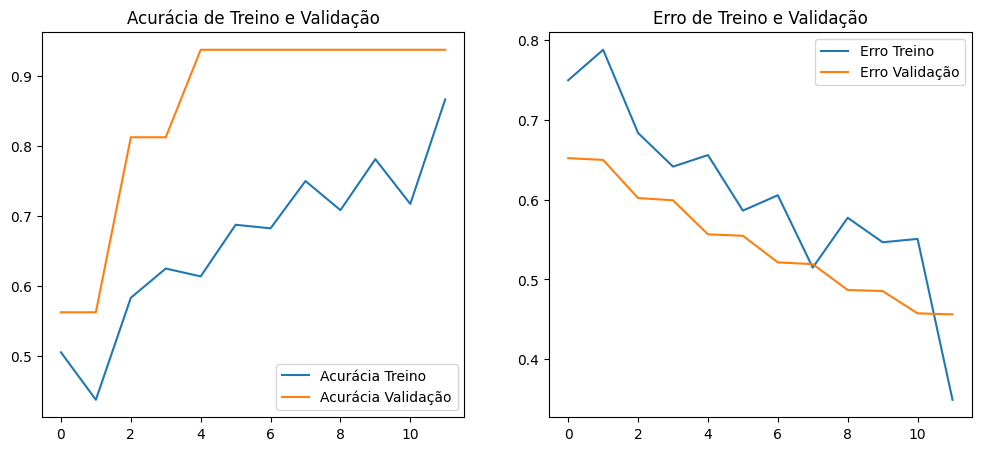

In [25]:
# Plotando as curvas de treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia Treino')
plt.plot(epochs_range, val_acc, label='Acurácia Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro Treino')
plt.plot(epochs_range, val_loss, label='Erro Validação')
plt.legend(loc='upper right')
plt.title('Erro de Treino e Validação')
plt.show()

## Avaliação 

- `test_generator.reset()` garante que o gerador de teste comece desde o início, especialmente se ele já foi usado antes.
- `model.predict(...)` Realiza predições para todas as imagens do conjunto de teste. `steps=test_generator.samples` Processa todas as amostras uma vez (batch size 1).
- `classification_report` Gera relatório detalhado com métricas como precisão, recall, F1-score e acurácia para cada classe, conforme pedido no trabalho.

In [ ]:
# Avaliação do modelo no conjunto de teste
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples)
# Como usa ativação sigmoide, limito a probabilidade em 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Extraindo as classes reais
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Imprime o relatório de classificação
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Relatório de Classificação:\n", report)

325/325 ━━━━━━━━━━━━━━━━━━━━ 53s 163ms/step
Relatório de Classificação:
               precision    recall  f1-score   support

     cracked       0.99      0.36      0.52       210
      normal       0.46      0.99      0.63       115

    accuracy                           0.58       325
   macro avg       0.72      0.67      0.58       325
weighted avg       0.80      0.58      0.56       325

